In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

from Notebook_helpers.load_data import *
from Notebook_helpers.modeling_helpers import *

## Load data

In [2]:
df, train, val, test = load_coral_data(complete=True, CV=False, convert_to_categorical=True)

#### Isolate features

In [5]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_X = train_X.drop(['Habitat_Modification', 'Invasive_Algae'], axis=1)
# train_X = train_X.drop(['Complexity', 'CHL_CLIM_M', 'WAV_ANOM_F', 'SST_CLIM_M'], axis=1)
train_y = train['Regime']

val_X = val.iloc[:, 14:34]
val_X = val_X.drop(['Habitat_Modification', 'Invasive_Algae'], axis=1)
# val_X = val_X.drop(['Complexity', 'CHL_CLIM_M', 'WAV_ANOM_F', 'SST_CLIM_M'], axis=1)
val_y = val['Regime']

pred_names = df.iloc[:, 14:34].columns

In [6]:
train_X.columns

Index(['Secondary', 'Effluent', 'Sedimentation', 'New_Development',
       'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_STD', 'CHL_ANOM_F', 'PAR_CLIM_M',
       'PAR_STD', 'WAV_CLIM_M'],
      dtype='object')

In [ ]:
Fishing_NonComm_Shore_Spear       2.858704
SST_STD                           2.611084
CHL_ANOM_F                        2.216701
PAR_CLIM_M                        3.297628
PAR_STD                           2.501900
WAV_CLIM_M                        2.819846

Complexity                        1.405406
Depth                             1.886404
CHL_CLIM_M                        1.827126
WAV_ANOM_F                        2.103854
SST_CLIM_M                        2.147285

#### Standardize

In [7]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

In [8]:
train_y = np.array(train_y, dtype=int)
val_y   = np.array(val_y, dtype=int)

In [11]:
train_X.shape

(396, 14)

In [9]:
def to_0_3(array):
    array = array.copy()
    array[array==1] = 0
    array[array==2] = 1
    array[array==3] = 2
    array[array==5] = 3
    return array
    
def back_to_1_5(array):
    array = array.copy()
    array[array==3] = 5
    array[array==2] = 3
    array[array==1] = 2
    array[array==0] = 1
    return array

In [10]:
print(train_y)
print(to_0_3(train_y))

[3 5 1 5 3 2 1 3 3 1 1 2 2 2 2 5 2 3 2 3 2 5 5 3 1 2 1 5 3 2 1 1 2 5 5 3 1
 3 1 2 5 3 2 2 1 2 3 5 5 2 3 2 1 2 5 1 2 5 3 5 1 3 5 2 5 3 5 1 5 5 1 1 1 1
 5 3 3 2 2 1 5 1 2 1 3 3 2 3 2 1 2 3 5 5 5 3 5 1 2 2 3 1 2 2 5 3 3 5 3 1 5
 2 5 1 3 5 5 1 3 1 3 2 5 1 2 3 1 5 5 1 3 5 1 5 1 2 3 2 3 2 3 5 2 5 2 1 5 5
 1 1 2 2 3 5 3 5 1 3 5 3 5 2 5 5 3 2 3 2 3 2 3 1 3 3 2 1 5 2 2 5 5 5 1 3 2
 5 5 1 2 5 2 3 2 5 2 3 3 1 1 2 1 3 5 3 2 3 2 3 5 5 2 2 5 2 2 2 2 5 1 5 2 3
 1 3 5 1 3 2 1 5 3 2 1 5 2 2 3 5 1 2 5 2 5 3 5 1 1 1 5 3 1 3 2 5 3 1 3 1 3
 2 2 1 1 5 2 2 3 1 1 3 2 2 5 2 2 2 2 2 3 1 5 3 1 2 3 2 1 2 3 1 1 2 5 2 2 1
 1 5 2 5 1 2 5 3 3 3 3 1 1 3 5 5 2 2 5 1 1 1 1 5 1 3 1 2 3 3 1 1 5 2 2 2 3
 5 1 1 2 1 5 1 1 3 5 1 2 1 1 1 2 3 1 2 3 3 1 2 5 2 1 5 5 5 3 5 2 3 1 5 2 3
 2 1 1 3 5 1 2 3 5 1 3 1 2 1 3 1 1 5 2 5 3 3 2 1 3 5]
[2 3 0 3 2 1 0 2 2 0 0 1 1 1 1 3 1 2 1 2 1 3 3 2 0 1 0 3 2 1 0 0 1 3 3 2 0
 2 0 1 3 2 1 1 0 1 2 3 3 1 2 1 0 1 3 0 1 3 2 3 0 2 3 1 3 2 3 0 3 3 0 0 0 0
 3 2 2 1 1 0 3 0 1 0 2 2 1 2 1 0 1 2 3 3 3 2 3

In [8]:
print(val_y)
print(to_0_3(val_y))

[2 2 5 5 2 3 1 1 5 5 5 2 5 5 2 2 1 3 5 3 2 3 5 3 1 1 5 5 2 1 3 1 2 3 2 3 5
 3 1 3 2 2 1 2 1 3 3 1 2 5 1 2 2 2 1 5 5 3 3 2 2 2 1 5 3 1 3 1 3 1 1 3 2 2
 3 5 1 2 1 1 5 3 3 2 5 3 1 1 3 1 2 1 2 1 5 3 5 2 2 3]
[1 1 3 3 1 2 0 0 3 3 3 1 3 3 1 1 0 2 3 2 1 2 3 2 0 0 3 3 1 0 2 0 1 2 1 2 3
 2 0 2 1 1 0 1 0 2 2 0 1 3 0 1 1 1 0 3 3 2 2 1 1 1 0 3 2 0 2 0 2 0 0 2 1 1
 2 3 0 1 0 0 3 2 2 1 3 2 0 0 2 0 1 0 1 0 3 2 3 1 1 2]


## Set up NN

In [12]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 396, 14, 30, 6

# Create random Tensors to hold inputs and outputs.
x = torch.FloatTensor(train_X)
y = torch.from_numpy(to_0_3(train_y))

val = torch.FloatTensor(val_X)
v_y = torch.from_numpy(to_0_3(val_y))

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

## Train NN

In [13]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []
val_loss = []
for t in range(10000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    y_val_pred = model(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
    loss_v = loss_fn(y_val_pred, v_y)
    val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.8144330978393555
1 1.8134454488754272
2 1.812459111213684
3 1.8114745616912842
4 1.8104912042617798
5 1.8095076084136963
6 1.8085271120071411
7 1.8075473308563232
8 1.8065680265426636
9 1.8055908679962158
10 1.8046144247055054
11 1.803637981414795
12 1.80266535282135
13 1.801693081855774
14 1.8007218837738037
15 1.79975163936615
16 1.7987834215164185
17 1.7978148460388184
18 1.7968493700027466
19 1.7958847284317017
20 1.7949203252792358
21 1.793956995010376
22 1.7929950952529907
23 1.7920368909835815
24 1.7910778522491455
25 1.7901228666305542
26 1.7891682386398315
27 1.788213849067688
28 1.7872605323791504
29 1.7863092422485352
30 1.785359263420105
31 1.7844105958938599
32 1.783462405204773
33 1.782516598701477
34 1.7815693616867065
35 1.7806276082992554
36 1.7796847820281982
37 1.7787433862686157
38 1.7778027057647705
39 1.7768644094467163
40 1.7759273052215576
41 1.7749894857406616
42 1.7740548849105835
43 1.7731200456619263
44 1.7721866369247437
45 1.7712558507919312
46 1.77032

381 1.492444634437561
382 1.4916435480117798
383 1.490843653678894
384 1.4900416135787964
385 1.4892406463623047
386 1.4884406328201294
387 1.487639307975769
388 1.4868402481079102
389 1.48604154586792
390 1.4852421283721924
391 1.4844427108764648
392 1.4836446046829224
393 1.4828464984893799
394 1.482047438621521
395 1.481250524520874
396 1.4804542064666748
397 1.4796556234359741
398 1.4788585901260376
399 1.4780614376068115
400 1.4772648811340332
401 1.4764697551727295
402 1.4756743907928467
403 1.4748769998550415
404 1.4740809202194214
405 1.473284363746643
406 1.4724888801574707
407 1.4716923236846924
408 1.4708961248397827
409 1.470101237297058
410 1.4693057537078857
411 1.4685121774673462
412 1.4677181243896484
413 1.4669241905212402
414 1.4661307334899902
415 1.465337872505188
416 1.4645453691482544
417 1.4637525081634521
418 1.462960124015808
419 1.4621678590774536
420 1.4613758325576782
421 1.4605834484100342
422 1.4597915410995483
423 1.4589996337890625
424 1.4582080841064453

847 1.1687710285186768
848 1.1682460308074951
849 1.1677199602127075
850 1.167195200920105
851 1.166671633720398
852 1.1661497354507446
853 1.1656280755996704
854 1.1651078462600708
855 1.1645885705947876
856 1.1640700101852417
857 1.1635520458221436
858 1.1630347967147827
859 1.1625181436538696
860 1.1620022058486938
861 1.1614874601364136
862 1.1609727144241333
863 1.1604593992233276
864 1.1599466800689697
865 1.159434199333191
866 1.1589239835739136
867 1.1584137678146362
868 1.1579053401947021
869 1.1573960781097412
870 1.1568894386291504
871 1.1563830375671387
872 1.1558783054351807
873 1.15537428855896
874 1.1548700332641602
875 1.154367208480835
876 1.1538660526275635
877 1.1533640623092651
878 1.1528635025024414
879 1.1523641347885132
880 1.151865005493164
881 1.1513673067092896
882 1.1508697271347046
883 1.1503732204437256
884 1.1498775482177734
885 1.1493829488754272
886 1.148888349533081
887 1.14839506149292
888 1.147902250289917
889 1.14741051197052
890 1.146919846534729
89

1332 0.9932156801223755
1333 0.9929741024971008
1334 0.9927334785461426
1335 0.9924933910369873
1336 0.9922530651092529
1337 0.9920139312744141
1338 0.9917756915092468
1339 0.9915366768836975
1340 0.991298258304596
1341 0.9910598397254944
1342 0.9908218383789062
1343 0.9905847907066345
1344 0.9903485178947449
1345 0.9901111721992493
1346 0.9898755550384521
1347 0.9896398782730103
1348 0.9894051551818848
1349 0.9891699552536011
1350 0.9889352321624756
1351 0.9887006878852844
1352 0.9884670376777649
1353 0.9882328510284424
1354 0.9879993200302124
1355 0.987765371799469
1356 0.9875330924987793
1357 0.9872999787330627
1358 0.9870671629905701
1359 0.9868350028991699
1360 0.9866024255752563
1361 0.9863702654838562
1362 0.9861382246017456
1363 0.9859073758125305
1364 0.9856753349304199
1365 0.9854447245597839
1366 0.9852132797241211
1367 0.9849830269813538
1368 0.9847524762153625
1369 0.98452228307724
1370 0.9842924475669861
1371 0.9840623736381531
1372 0.9838325381278992
1373 0.9836028814315

1706 0.9180976152420044
1707 0.9179248809814453
1708 0.9177519679069519
1709 0.9175794720649719
1710 0.9174066185951233
1711 0.9172341823577881
1712 0.917061984539032
1713 0.9168896675109863
1714 0.9167173504829407
1715 0.9165446162223816
1716 0.9163726568222046
1717 0.9162006378173828
1718 0.9160285592079163
1719 0.915856659412384
1720 0.9156846404075623
1721 0.9155126810073853
1722 0.9153409004211426
1723 0.9151703715324402
1724 0.9149990081787109
1725 0.9148280024528503
1726 0.9146565198898315
1727 0.9144862294197083
1728 0.9143156409263611
1729 0.9141448736190796
1730 0.9139744639396667
1731 0.9138044714927673
1732 0.9136342406272888
1733 0.9134637713432312
1734 0.9132940769195557
1735 0.9131247997283936
1736 0.9129544496536255
1737 0.912784993648529
1738 0.9126154780387878
1739 0.9124458432197571
1740 0.9122769236564636
1741 0.9121081233024597
1742 0.9119386672973633
1743 0.9117695689201355
1744 0.9116013646125793
1745 0.9114325642585754
1746 0.911263644695282
1747 0.9110961556434

2087 0.8588505983352661
2088 0.8587071299552917
2089 0.8585639595985413
2090 0.8584203124046326
2091 0.8582778573036194
2092 0.8581343293190002
2093 0.857991099357605
2094 0.8578476309776306
2095 0.857704222202301
2096 0.8575611114501953
2097 0.8574183583259583
2098 0.857275128364563
2099 0.8571324348449707
2100 0.8569895625114441
2101 0.8568464517593384
2102 0.8567039966583252
2103 0.8565618395805359
2104 0.8564189076423645
2105 0.8562756776809692
2106 0.8561331033706665
2107 0.8559897541999817
2108 0.8558467626571655
2109 0.8557040095329285
2110 0.855561375617981
2111 0.8554185032844543
2112 0.8552756905555725
2113 0.8551324605941772
2114 0.854989767074585
2115 0.8548474311828613
2116 0.8547047972679138
2117 0.8545619249343872
2118 0.8544192910194397
2119 0.854276716709137
2120 0.8541338443756104
2121 0.8539912700653076
2122 0.8538489937782288
2123 0.8537053465843201
2124 0.8535624742507935
2125 0.853419840335846
2126 0.8532766699790955
2127 0.8531336188316345
2128 0.8529902100563049

2437 0.8111618757247925
2438 0.8110323548316956
2439 0.8109027743339539
2440 0.8107742667198181
2441 0.8106446862220764
2442 0.8105155825614929
2443 0.8103861212730408
2444 0.8102563619613647
2445 0.8101267218589783
2446 0.8099973797798157
2447 0.8098683953285217
2448 0.8097397685050964
2449 0.8096099495887756
2450 0.8094805479049683
2451 0.8093510866165161
2452 0.8092220425605774
2453 0.8090927600860596
2454 0.8089629411697388
2455 0.8088331818580627
2456 0.8087040185928345
2457 0.8085749745368958
2458 0.8084462285041809
2459 0.8083170652389526
2460 0.8081874847412109
2461 0.8080587387084961
2462 0.8079294562339783
2463 0.80780029296875
2464 0.8076713681221008
2465 0.8075416684150696
2466 0.8074129819869995
2467 0.8072846531867981
2468 0.807154655456543
2469 0.8070263862609863
2470 0.8068972229957581
2471 0.8067682385444641
2472 0.8066385388374329
2473 0.8065098524093628
2474 0.8063807487487793
2475 0.8062517046928406
2476 0.806122899055481
2477 0.8059939742088318
2478 0.8058649897575

2781 0.7673332691192627
2782 0.7672087550163269
2783 0.7670848369598389
2784 0.7669603228569031
2785 0.7668360471725464
2786 0.7667122483253479
2787 0.7665889859199524
2788 0.7664645910263062
2789 0.7663404941558838
2790 0.7662169337272644
2791 0.7660929560661316
2792 0.7659685015678406
2793 0.7658447027206421
2794 0.7657201886177063
2795 0.7655960321426392
2796 0.765471875667572
2797 0.7653480172157288
2798 0.765224039554596
2799 0.7650997042655945
2800 0.7649756669998169
2801 0.7648516297340393
2802 0.7647275328636169
2803 0.7646037936210632
2804 0.7644797563552856
2805 0.7643551826477051
2806 0.7642319202423096
2807 0.7641080617904663
2808 0.7639846801757812
2809 0.7638610601425171
2810 0.7637372016906738
2811 0.7636129260063171
2812 0.7634891271591187
2813 0.7633650898933411
2814 0.7632409930229187
2815 0.7631171345710754
2816 0.7629925608634949
2817 0.7628676891326904
2818 0.7627437114715576
2819 0.7626190781593323
2820 0.7624951601028442
2821 0.762370228767395
2822 0.762245714664

3185 0.7193536758422852
3186 0.7192387580871582
3187 0.719123899936676
3188 0.7190096974372864
3189 0.7188944220542908
3190 0.7187792062759399
3191 0.718664288520813
3192 0.7185491919517517
3193 0.7184333205223083
3194 0.7183182835578918
3195 0.7182021737098694
3196 0.7180867195129395
3197 0.7179707288742065
3198 0.7178544998168945
3199 0.7177390456199646
3200 0.7176229953765869
3201 0.7175071835517883
3202 0.7173911333084106
3203 0.7172753810882568
3204 0.7171592116355896
3205 0.7170430421829224
3206 0.716928243637085
3207 0.7168142795562744
3208 0.7166995406150818
3209 0.7165852785110474
3210 0.71647047996521
3211 0.7163564562797546
3212 0.7162421345710754
3213 0.7161276340484619
3214 0.7160134315490723
3215 0.7158989906311035
3216 0.7157851457595825
3217 0.7156708836555481
3218 0.7155563831329346
3219 0.7154428362846375
3220 0.7153289318084717
3221 0.7152146697044373
3222 0.7151004672050476
3223 0.71498703956604
3224 0.714873194694519
3225 0.714759349822998
3226 0.7146456837654114
3

3577 0.6763335466384888
3578 0.6762269735336304
3579 0.6761200428009033
3580 0.6760123372077942
3581 0.6759049296379089
3582 0.6757975816726685
3583 0.6756905317306519
3584 0.6755831241607666
3585 0.6754758954048157
3586 0.6753680109977722
3587 0.6752609014511108
3588 0.6751531958580017
3589 0.6750456094741821
3590 0.6749389171600342
3591 0.674831211566925
3592 0.6747235655784607
3593 0.6746167540550232
3594 0.6745092272758484
3595 0.6744021773338318
3596 0.6742948889732361
3597 0.674187421798706
3598 0.6740806102752686
3599 0.6739738583564758
3600 0.6738666296005249
3601 0.6737594604492188
3602 0.6736523509025574
3603 0.6735460758209229
3604 0.6734392046928406
3605 0.6733320355415344
3606 0.6732255816459656
3607 0.6731182336807251
3608 0.673011302947998
3609 0.6729047894477844
3610 0.6727976202964783
3611 0.6726913452148438
3612 0.6725844740867615
3613 0.6724780797958374
3614 0.6723710894584656
3615 0.6722649335861206
3616 0.6721583604812622
3617 0.6720521450042725
3618 0.671945691108

4003 0.6315916180610657
4004 0.6314892172813416
4005 0.6313868165016174
4006 0.6312843561172485
4007 0.6311814785003662
4008 0.6310793161392212
4009 0.630976676940918
4010 0.6308741569519043
4011 0.6307714581489563
4012 0.6306688189506531
4013 0.6305664777755737
4014 0.6304644346237183
4015 0.6303614377975464
4016 0.6302593350410461
4017 0.6301569938659668
4018 0.630054771900177
4019 0.6299524903297424
4020 0.6298499703407288
4021 0.6297473907470703
4022 0.629645049571991
4023 0.6295439600944519
4024 0.6294423937797546
4025 0.6293407678604126
4026 0.6292383670806885
4027 0.6291366219520569
4028 0.6290349960327148
4029 0.628933310508728
4030 0.6288313269615173
4031 0.6287294626235962
4032 0.628627598285675
4033 0.6285254955291748
4034 0.6284239292144775
4035 0.6283217072486877
4036 0.6282199621200562
4037 0.6281180381774902
4038 0.6280155181884766
4039 0.6279131174087524
4040 0.6278101801872253
4041 0.6277077198028564
4042 0.6276054382324219
4043 0.6275025010108948
4044 0.62740045785903

4569 0.5773796439170837
4570 0.5772930979728699
4571 0.577206015586853
4572 0.5771189332008362
4573 0.5770323872566223
4574 0.5769459009170532
4575 0.5768593549728394
4576 0.5767732858657837
4577 0.5766863226890564
4578 0.5766001343727112
4579 0.576513409614563
4580 0.5764276385307312
4581 0.5763413906097412
4582 0.5762550830841064
4583 0.5761685967445374
4584 0.5760819911956787
4585 0.575995683670044
4586 0.5759095549583435
4587 0.5758227109909058
4588 0.5757361650466919
4589 0.575650155544281
4590 0.5755643844604492
4591 0.5754777789115906
4592 0.5753915309906006
4593 0.575305700302124
4594 0.5752199292182922
4595 0.5751335620880127
4596 0.5750477910041809
4597 0.5749620795249939
4598 0.5748764276504517
4599 0.5747902393341064
4600 0.5747047662734985
4601 0.574619472026825
4602 0.5745336413383484
4603 0.5744479298591614
4604 0.5743619203567505
4605 0.5742766857147217
4606 0.5741909146308899
4607 0.5741055607795715
4608 0.5740203261375427
4609 0.5739348530769348
4610 0.573848843574523

4933 0.5480441451072693
4934 0.5479665994644165
4935 0.5478904247283936
4936 0.5478127598762512
4937 0.5477356910705566
4938 0.5476586222648621
4939 0.5475813150405884
4940 0.5475040078163147
4941 0.5474264621734619
4942 0.5473493337631226
4943 0.5472719669342041
4944 0.5471944212913513
4945 0.547117292881012
4946 0.5470401644706726
4947 0.5469633936882019
4948 0.5468862652778625
4949 0.5468087792396545
4950 0.5467308163642883
4951 0.546653687953949
4952 0.5465771555900574
4953 0.546500027179718
4954 0.54642254114151
4955 0.5463458299636841
4956 0.5462687611579895
4957 0.5461921095848083
4958 0.5461159944534302
4959 0.5460394024848938
4960 0.5459622740745544
4961 0.5458860993385315
4962 0.5458096861839294
4963 0.5457326769828796
4964 0.5456553101539612
4965 0.5455789566040039
4966 0.5455029606819153
4967 0.5454260110855103
4968 0.5453482866287231
4969 0.5452719926834106
4970 0.5451946258544922
4971 0.5451181530952454
4972 0.5450403094291687
4973 0.5449637770652771
4974 0.54488694667816

5287 0.5209304094314575
5288 0.5208548307418823
5289 0.520778477191925
5290 0.5207030773162842
5291 0.520628035068512
5292 0.5205523371696472
5293 0.5204761624336243
5294 0.5204007029533386
5295 0.5203254222869873
5296 0.5202503204345703
5297 0.5201747417449951
5298 0.5200992822647095
5299 0.520023763179779
5300 0.5199486017227173
5301 0.5198732018470764
5302 0.5197979211807251
5303 0.5197221040725708
5304 0.5196466445922852
5305 0.5195710062980652
5306 0.5194967985153198
5307 0.5194215178489685
5308 0.519345223903656
5309 0.5192704796791077
5310 0.5191951990127563
5311 0.5191207528114319
5312 0.5190449357032776
5313 0.5189698338508606
5314 0.518895149230957
5315 0.5188208222389221
5316 0.5187466740608215
5317 0.5186727643013
5318 0.5185986757278442
5319 0.5185245871543884
5320 0.5184499621391296
5321 0.5183764100074768
5322 0.5183027982711792
5323 0.5182294845581055
5324 0.5181562304496765
5325 0.5180830359458923
5326 0.5180097818374634
5327 0.5179368853569031
5328 0.5178635120391846


5772 0.4867275059223175
5773 0.4866584241390228
5774 0.4865895211696625
5775 0.4865209460258484
5776 0.48645269870758057
5777 0.4863833487033844
5778 0.4863145351409912
5779 0.48624566197395325
5780 0.48617711663246155
5781 0.4861086905002594
5782 0.486039400100708
5783 0.48597031831741333
5784 0.4859016239643097
5785 0.4858337640762329
5786 0.4857647120952606
5787 0.4856957197189331
5788 0.48562657833099365
5789 0.48555809259414673
5790 0.48548996448516846
5791 0.48542097210884094
5792 0.4853519797325134
5793 0.48528411984443665
5794 0.48521527647972107
5795 0.4851468801498413
5796 0.4850795567035675
5797 0.48501208424568176
5798 0.484944224357605
5799 0.48487722873687744
5800 0.48480919003486633
5801 0.4847414493560791
5802 0.4846748113632202
5803 0.48460713028907776
5804 0.48453885316848755
5805 0.48447132110595703
5806 0.4844035804271698
5807 0.4843365550041199
5808 0.48426946997642517
5809 0.484202116727829
5810 0.48413458466529846
5811 0.4840672016143799
5812 0.4840009808540344
5

6134 0.46433722972869873
6135 0.46427953243255615
6136 0.46422079205513
6137 0.46416258811950684
6138 0.4641038477420807
6139 0.4640447795391083
6140 0.4639867842197418
6141 0.4639294147491455
6142 0.4638712704181671
6143 0.46381136775016785
6144 0.46375343203544617
6145 0.46369561553001404
6146 0.4636373519897461
6147 0.4635786712169647
6148 0.46352046728134155
6149 0.46346214413642883
6150 0.4634045660495758
6151 0.4633469879627228
6152 0.4632883071899414
6153 0.4632301330566406
6154 0.4631718695163727
6155 0.4631134271621704
6156 0.46305593848228455
6157 0.4629971981048584
6158 0.46293848752975464
6159 0.46288061141967773
6160 0.4628235399723053
6161 0.46276459097862244
6162 0.4627058506011963
6163 0.46264857053756714
6164 0.46259069442749023
6165 0.4625321626663208
6166 0.46247416734695435
6167 0.462415874004364
6168 0.46235722303390503
6169 0.4622995853424072
6170 0.46224164962768555
6171 0.46218371391296387
6172 0.46212586760520935
6173 0.46206796169281006
6174 0.4620110988616943

6484 0.44500231742858887
6485 0.44494864344596863
6486 0.4448948800563812
6487 0.44484078884124756
6488 0.4447866380214691
6489 0.44473332166671753
6490 0.4446793794631958
6491 0.44462478160858154
6492 0.4445713758468628
6493 0.44451823830604553
6494 0.44446417689323425
6495 0.44440963864326477
6496 0.44435635209083557
6497 0.4443022906780243
6498 0.4442480802536011
6499 0.4441949725151062
6500 0.44414061307907104
6501 0.4440864324569702
6502 0.4440321624279022
6503 0.4439789056777954
6504 0.4439254105091095
6505 0.44387081265449524
6506 0.44381728768348694
6507 0.4437638521194458
6508 0.4437101483345032
6509 0.44365596771240234
6510 0.4436022937297821
6511 0.44354861974716187
6512 0.4434947669506073
6513 0.4434411823749542
6514 0.44338807463645935
6515 0.4433343708515167
6516 0.4432799518108368
6517 0.44322681427001953
6518 0.44317346811294556
6519 0.4431205987930298
6520 0.44306620955467224
6521 0.443012535572052
6522 0.4429585337638855
6523 0.4429050385951996
6524 0.4428515136241913

6923 0.4221496284008026
6924 0.42209768295288086
6925 0.4220461845397949
6926 0.4219955801963806
6927 0.4219442903995514
6928 0.42189279198646545
6929 0.4218415915966034
6930 0.4217906892299652
6931 0.4217393696308136
6932 0.4216887056827545
6933 0.4216383993625641
6934 0.4215865731239319
6935 0.421536386013031
6936 0.4214860200881958
6937 0.421435683965683
6938 0.42138588428497314
6939 0.4213355779647827
6940 0.42128506302833557
6941 0.421235054731369
6942 0.42118531465530396
6943 0.4211341142654419
6944 0.42108407616615295
6945 0.4210350215435028
6946 0.4209844768047333
6947 0.4209342300891876
6948 0.420884370803833
6949 0.4208342730998993
6950 0.42078453302383423
6951 0.42073535919189453
6952 0.42068538069725037
6953 0.420634925365448
6954 0.42058488726615906
6955 0.42053502798080444
6956 0.42048510909080505
6957 0.42043453454971313
6958 0.42038479447364807
6959 0.4203343987464905
6960 0.42028436064720154
6961 0.4202340543270111
6962 0.420184463262558
6963 0.4201343059539795
6964 0.

7301 0.4037725329399109
7302 0.4037233889102936
7303 0.4036749601364136
7304 0.4036262631416321
7305 0.40357664227485657
7306 0.40352824330329895
7307 0.4034794867038727
7308 0.4034307897090912
7309 0.4033823013305664
7310 0.40333399176597595
7311 0.4032851755619049
7312 0.40323665738105774
7313 0.4031880795955658
7314 0.40313926339149475
7315 0.40309178829193115
7316 0.40304210782051086
7317 0.40299373865127563
7318 0.40294545888900757
7319 0.40289631485939026
7320 0.4028477668762207
7321 0.4027993679046631
7322 0.4027511477470398
7323 0.4027026295661926
7324 0.40265336632728577
7325 0.4026050865650177
7326 0.40255728363990784
7327 0.40250882506370544
7328 0.40246081352233887
7329 0.4024117887020111
7330 0.402363121509552
7331 0.4023149013519287
7332 0.40226635336875916
7333 0.40221840143203735
7334 0.40216994285583496
7335 0.40212225914001465
7336 0.40207457542419434
7337 0.40202608704566956
7338 0.4019787013530731
7339 0.40193137526512146
7340 0.4018832743167877
7341 0.4018346667289

7698 0.3854275345802307
7699 0.3853827118873596
7700 0.38533833622932434
7701 0.3852927088737488
7702 0.38524800539016724
7703 0.38520315289497375
7704 0.385158509016037
7705 0.385113000869751
7706 0.3850688338279724
7707 0.3850235641002655
7708 0.38497844338417053
7709 0.38493385910987854
7710 0.3848887085914612
7711 0.38484400510787964
7712 0.3847990036010742
7713 0.3847540020942688
7714 0.3847094178199768
7715 0.3846646249294281
7716 0.38461950421333313
7717 0.38457462191581726
7718 0.3845300078392029
7719 0.3844851553440094
7720 0.38444095849990845
7721 0.38439667224884033
7722 0.3843512535095215
7723 0.3843073546886444
7724 0.38426288962364197
7725 0.3842181861400604
7726 0.3841739296913147
7727 0.3841302692890167
7728 0.38408607244491577
7729 0.38404178619384766
7730 0.3839975595474243
7731 0.38395294547080994
7732 0.3839090168476105
7733 0.38386455178260803
7734 0.3838207721710205
7735 0.3837764263153076
7736 0.38373225927352905
7737 0.3836880326271057
7738 0.3836437165737152
77

8044 0.3702890872955322
8045 0.3702467083930969
8046 0.3702024519443512
8047 0.3701586127281189
8048 0.37011536955833435
8049 0.3700718879699707
8050 0.37002891302108765
8051 0.3699866533279419
8052 0.36994314193725586
8053 0.3698999881744385
8054 0.3698565661907196
8055 0.36981359124183655
8056 0.3697711229324341
8057 0.3697277307510376
8058 0.36968469619750977
8059 0.3696417808532715
8060 0.3695983588695526
8061 0.3695547580718994
8062 0.3695124089717865
8063 0.36946961283683777
8064 0.36942654848098755
8065 0.36938419938087463
8066 0.3693409562110901
8067 0.36929845809936523
8068 0.3692573010921478
8069 0.36921438574790955
8070 0.36917221546173096
8071 0.3691295385360718
8072 0.3690871000289917
8073 0.3690439760684967
8074 0.36900225281715393
8075 0.36895951628685
8076 0.36891722679138184
8077 0.3688752055168152
8078 0.3688329756259918
8079 0.3687913417816162
8080 0.36874932050704956
8081 0.3687073588371277
8082 0.3686648905277252
8083 0.3686225712299347
8084 0.36858075857162476
808

8419 0.3551185727119446
8420 0.35508084297180176
8421 0.3550410866737366
8422 0.35500192642211914
8423 0.354963093996048
8424 0.3549237847328186
8425 0.3548852205276489
8426 0.35484713315963745
8427 0.35480889678001404
8428 0.35476985573768616
8429 0.35473158955574036
8430 0.3546925485134125
8431 0.35465407371520996
8432 0.3546156585216522
8433 0.3545764982700348
8434 0.35453811287879944
8435 0.3544999957084656
8436 0.3544619083404541
8437 0.3544227182865143
8438 0.3543834388256073
8439 0.35434553027153015
8440 0.3543073832988739
8441 0.3542684018611908
8442 0.3542303144931793
8443 0.3541921377182007
8444 0.35415372252464294
8445 0.3541144132614136
8446 0.35407504439353943
8447 0.3540366590023041
8448 0.3539978861808777
8449 0.3539603352546692
8450 0.35392192006111145
8451 0.35388365387916565
8452 0.35384437441825867
8453 0.3538062274456024
8454 0.3537678122520447
8455 0.3537290096282959
8456 0.3536904752254486
8457 0.353652685880661
8458 0.3536131978034973
8459 0.35357508063316345
846

8805 0.3401249945163727
8806 0.34008708596229553
8807 0.3400486409664154
8808 0.34001004695892334
8809 0.3399716317653656
8810 0.3399333655834198
8811 0.33989477157592773
8812 0.3398555517196655
8813 0.33981770277023315
8814 0.3397798240184784
8815 0.3397408723831177
8816 0.33970263600349426
8817 0.33966487646102905
8818 0.33962684869766235
8819 0.3395887017250061
8820 0.3395501375198364
8821 0.33951178193092346
8822 0.3394729793071747
8823 0.339434951543808
8824 0.3393954932689667
8825 0.3393577039241791
8826 0.3393189013004303
8827 0.3392803966999054
8828 0.33924221992492676
8829 0.33920392394065857
8830 0.33916616439819336
8831 0.3391275107860565
8832 0.3390885889530182
8833 0.33905065059661865
8834 0.33901333808898926
8835 0.33897510170936584
8836 0.3389359414577484
8837 0.33889758586883545
8838 0.33885878324508667
8839 0.3388199508190155
8840 0.3387819826602936
8841 0.3387433886528015
8842 0.33870527148246765
8843 0.3386673629283905
8844 0.3386297821998596
8845 0.33859121799468994

9198 0.32565730810165405
9199 0.3256230354309082
9200 0.3255883753299713
9201 0.32555365562438965
9202 0.3255179524421692
9203 0.32548296451568604
9204 0.3254479169845581
9205 0.3254121243953705
9206 0.32537707686424255
9207 0.32534268498420715
9208 0.3253086805343628
9209 0.32527434825897217
9210 0.3252386748790741
9211 0.3252035081386566
9212 0.3251693844795227
9213 0.32513466477394104
9214 0.3250992000102997
9215 0.32506459951400757
9216 0.32502955198287964
9217 0.32499489188194275
9218 0.3249601423740387
9219 0.32492566108703613
9220 0.3248915672302246
9221 0.32485660910606384
9222 0.32482144236564636
9223 0.3247871398925781
9224 0.32475319504737854
9225 0.3247179687023163
9226 0.3246837854385376
9227 0.3246478736400604
9228 0.3246135115623474
9229 0.32457974553108215
9230 0.32454541325569153
9231 0.32451027631759644
9232 0.3244755268096924
9233 0.32444146275520325
9234 0.3244064748287201
9235 0.3243725001811981
9236 0.3243385851383209
9237 0.32430407404899597
9238 0.32426890730857

9664 0.31003251671791077
9665 0.3099999725818634
9666 0.3099684715270996
9667 0.3099361062049866
9668 0.3099038302898407
9669 0.30987152457237244
9670 0.30983954668045044
9671 0.30980685353279114
9672 0.30977457761764526
9673 0.30974292755126953
9674 0.3097115755081177
9675 0.30967846512794495
9676 0.3096459209918976
9677 0.3096138834953308
9678 0.30958178639411926
9679 0.3095497786998749
9680 0.3095179796218872
9681 0.3094851076602936
9682 0.30945348739624023
9683 0.30942097306251526
9684 0.30938947200775146
9685 0.3093571960926056
9686 0.30932480096817017
9687 0.3092925250530243
9688 0.3092604875564575
9689 0.30922865867614746
9690 0.3091970682144165
9691 0.3091649115085602
9692 0.3091329336166382
9693 0.3091006875038147
9694 0.3090689480304718
9695 0.3090374171733856
9696 0.3090052306652069
9697 0.30897340178489685
9698 0.30894118547439575
9699 0.3089083135128021
9700 0.3088768720626831
9701 0.3088443875312805
9702 0.3088131844997406
9703 0.3087809383869171
9704 0.3087484836578369
9

In [14]:
scores = model(torch.FloatTensor(train_X))
scores_np = scores.detach().numpy()

estimates = np.argmax(scores_np, axis=1)

Misclassified samples: 45
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.93      0.92        99
           2       0.86      0.88      0.87       104
           3       0.88      0.87      0.88        94
           5       0.89      0.86      0.88        99

   micro avg       0.89      0.89      0.89       396
   macro avg       0.89      0.89      0.89       396
weighted avg       0.89      0.89      0.89       396



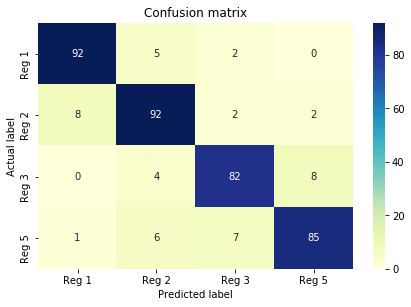

In [15]:
evaluate_performance(back_to_1_5(estimates), train_y)

### Validation

In [16]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 39
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.57      0.61        30
           2       0.61      0.59      0.60        29
           3       0.68      0.61      0.64        28
           5       0.48      0.77      0.59        13

   micro avg       0.61      0.61      0.61       100
   macro avg       0.60      0.63      0.61       100
weighted avg       0.62      0.61      0.61       100



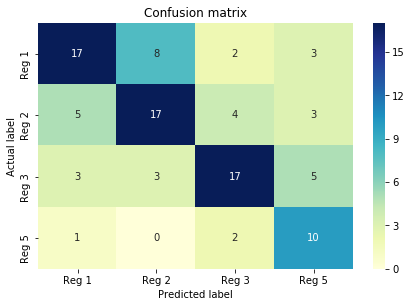

In [17]:
evaluate_performance(back_to_1_5(val_estimates), val_y)

### Bias-Variance Tradeoff

Text(0.5, 1.0, 'Training Loss')

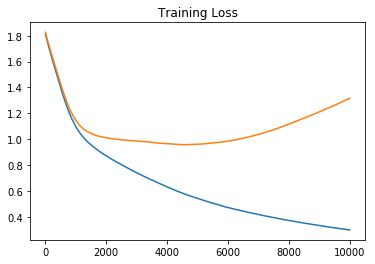

In [18]:
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title("Training Loss")

In [18]:
np.argmin(val_loss)

2513

## Retrain for the optimal number of epochs

In [25]:
# Use the nn package to define our model and loss function.
model2 = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

In [29]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=0.1)
train_loss = []
val_loss = []
for t in range(2500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model2(x)
#     y_val_pred = model2(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
#     loss_v = loss_fn(y_val_pred, v_y)
#     val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.7258516550064087
1 1.7257012128829956
2 1.7255498170852661
3 1.7253966331481934
4 1.7252439260482788
5 1.725090742111206
6 1.724936842918396
7 1.7247810363769531
8 1.724625825881958
9 1.7244693040847778
10 1.7243119478225708
11 1.7241551876068115
12 1.7239949703216553
13 1.723836064338684
14 1.7236748933792114
15 1.7235124111175537
16 1.7233504056930542
17 1.7231873273849487
18 1.723021388053894
19 1.7228556871414185
20 1.722688913345337
21 1.7225210666656494
22 1.7223517894744873
23 1.722181797027588
24 1.7220097780227661
25 1.7218375205993652
26 1.7216624021530151
27 1.721486210823059
28 1.7213090658187866
29 1.7211319208145142
30 1.7209508419036865
31 1.7207694053649902
32 1.7205862998962402
33 1.7204010486602783
34 1.7202153205871582
35 1.7200261354446411
36 1.7198361158370972
37 1.7196446657180786
38 1.7194507122039795
39 1.719254732131958
40 1.7190567255020142
41 1.7188572883605957
42 1.718654751777649
43 1.7184518575668335
44 1.7182457447052002
45 1.7180380821228027
46 1.717

408 1.4463013410568237
409 1.4454045295715332
410 1.444509744644165
411 1.4436166286468506
412 1.442725419998169
413 1.4418361186981201
414 1.440947413444519
415 1.4400599002838135
416 1.4391758441925049
417 1.4382925033569336
418 1.4374096393585205
419 1.4365301132202148
420 1.4356516599655151
421 1.43477463722229
422 1.4339005947113037
423 1.433027982711792
424 1.4321560859680176
425 1.4312855005264282
426 1.4304187297821045
427 1.4295508861541748
428 1.4286868572235107
429 1.4278218746185303
430 1.4269614219665527
431 1.4261009693145752
432 1.4252429008483887
433 1.4243860244750977
434 1.4235312938690186
435 1.4226778745651245
436 1.4218261241912842
437 1.420975923538208
438 1.420127272605896
439 1.4192811250686646
440 1.418436050415039
441 1.4175937175750732
442 1.416751742362976
443 1.4159128665924072
444 1.4150753021240234
445 1.4142398834228516
446 1.4134044647216797
447 1.4125735759735107
448 1.411742091178894
449 1.4109145402908325
450 1.4100879430770874
451 1.4092638492584229

823 1.2042264938354492
824 1.2038805484771729
825 1.203534483909607
826 1.2031899690628052
827 1.2028460502624512
828 1.2025028467178345
829 1.2021592855453491
830 1.2018160820007324
831 1.201473593711853
832 1.2011325359344482
833 1.2007924318313599
834 1.2004528045654297
835 1.200114130973816
836 1.1997753381729126
837 1.1994380950927734
838 1.1991009712219238
839 1.1987650394439697
840 1.1984299421310425
841 1.1980953216552734
842 1.1977614164352417
843 1.197427749633789
844 1.1970958709716797
845 1.196763515472412
846 1.1964330673217773
847 1.1961028575897217
848 1.1957740783691406
849 1.1954454183578491
850 1.1951175928115845
851 1.1947920322418213
852 1.1944659948349
853 1.1941405534744263
854 1.1938157081604004
855 1.1934927701950073
856 1.1931699514389038
857 1.1928476095199585
858 1.1925262212753296
859 1.1922048330307007
860 1.1918830871582031
861 1.1915640830993652
862 1.19124436378479
863 1.190925121307373
864 1.1906070709228516
865 1.1902896165847778
866 1.1899731159210205

1269 1.1040993928909302
1270 1.1039636135101318
1271 1.103827714920044
1272 1.1036936044692993
1273 1.1035586595535278
1274 1.103425145149231
1275 1.1032905578613281
1276 1.1031569242477417
1277 1.1030229330062866
1278 1.1028894186019897
1279 1.1027557849884033
1280 1.1026233434677124
1281 1.1024889945983887
1282 1.102357029914856
1283 1.10222327709198
1284 1.1020914316177368
1285 1.1019606590270996
1286 1.1018298864364624
1287 1.101699709892273
1288 1.1015691757202148
1289 1.1014394760131836
1290 1.1013094186782837
1291 1.1011791229248047
1292 1.1010496616363525
1293 1.1009223461151123
1294 1.1007938385009766
1295 1.1006660461425781
1296 1.1005382537841797
1297 1.1004114151000977
1298 1.1002849340438843
1299 1.1001580953598022
1300 1.1000300645828247
1301 1.0999038219451904
1302 1.0997765064239502
1303 1.0996506214141846
1304 1.0995246171951294
1305 1.099399209022522
1306 1.0992727279663086
1307 1.0991462469100952
1308 1.0990203619003296
1309 1.0988948345184326
1310 1.098770022392273


1652 1.0681325197219849
1653 1.0680691003799438
1654 1.0680056810379028
1655 1.067941665649414
1656 1.067878007888794
1657 1.0678154230117798
1658 1.0677523612976074
1659 1.0676898956298828
1660 1.0676270723342896
1661 1.0675626993179321
1662 1.0674989223480225
1663 1.0674346685409546
1664 1.0673713684082031
1665 1.0673071146011353
1666 1.0672435760498047
1667 1.0671803951263428
1668 1.0671168565750122
1669 1.0670528411865234
1670 1.0669894218444824
1671 1.0669260025024414
1672 1.0668636560440063
1673 1.0668001174926758
1674 1.0667376518249512
1675 1.0666743516921997
1676 1.066610336303711
1677 1.0665467977523804
1678 1.0664836168289185
1679 1.0664215087890625
1680 1.0663586854934692
1681 1.066295862197876
1682 1.0662332773208618
1683 1.0661709308624268
1684 1.0661096572875977
1685 1.0660470724105835
1686 1.0659846067428589
1687 1.0659222602844238
1688 1.0658600330352783
1689 1.0657991170883179
1690 1.0657384395599365
1691 1.0656780004501343
1692 1.0656176805496216
1693 1.0655574798583

2077 1.0460795164108276
2078 1.0460387468338013
2079 1.0459964275360107
2080 1.0459550619125366
2081 1.045912265777588
2082 1.0458698272705078
2083 1.0458288192749023
2084 1.0457874536514282
2085 1.045745849609375
2086 1.0457038879394531
2087 1.0456616878509521
2088 1.0456204414367676
2089 1.0455788373947144
2090 1.0455372333526611
2091 1.0454957485198975
2092 1.0454540252685547
2093 1.0454124212265015
2094 1.0453710556030273
2095 1.045328974723816
2096 1.0452885627746582
2097 1.0452473163604736
2098 1.04520583152771
2099 1.045164942741394
2100 1.0451245307922363
2101 1.0450830459594727
2102 1.0450425148010254
2103 1.0450019836425781
2104 1.0449604988098145
2105 1.0449188947677612
2106 1.044878363609314
2107 1.0448366403579712
2108 1.0447957515716553
2109 1.0447545051574707
2110 1.0447131395339966
2111 1.0446720123291016
2112 1.0446313619613647
2113 1.0445915460586548
2114 1.0445507764816284
2115 1.0445111989974976
2116 1.0444711446762085
2117 1.0444315671920776
2118 1.0443918704986572

2479 1.0315728187561035
2480 1.031539797782898
2481 1.0315066576004028
2482 1.0314732789993286
2483 1.03144109249115
2484 1.0314081907272339
2485 1.0313773155212402
2486 1.0313470363616943
2487 1.0313156843185425
2488 1.0312838554382324
2489 1.0312516689300537
2490 1.0312193632125854
2491 1.0311884880065918
2492 1.0311572551727295
2493 1.0311263799667358
2494 1.0310956239700317
2495 1.0310648679733276
2496 1.0310349464416504
2497 1.0310041904449463
2498 1.0309736728668213
2499 1.0309438705444336


In [30]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 35
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.66      0.69        29
           2       0.64      0.58      0.61        31
           3       0.64      0.67      0.65        24
           5       0.57      0.75      0.65        16

   micro avg       0.65      0.65      0.65       100
   macro avg       0.65      0.66      0.65       100
weighted avg       0.66      0.65      0.65       100



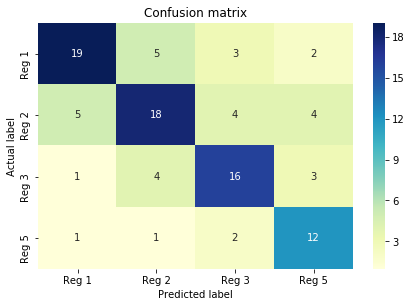

In [31]:
evaluate_performance(back_to_1_5(val_estimates), val_y)

# Add Regularization

## Set up NN

In [19]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 396, 14, 30, 6

# Create random Tensors to hold inputs and outputs.
x = torch.FloatTensor(train_X)
y = torch.from_numpy(to_0_3(train_y))

val = torch.FloatTensor(val_X)
v_y = torch.from_numpy(to_0_3(val_y))

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

## Train NN

In [20]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.05)
train_loss = []
val_loss = []
for t in range(10000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    y_val_pred = model(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
    loss_v = loss_fn(y_val_pred, v_y)
    val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.7848904132843018
1 1.7839990854263306
2 1.7831079959869385
3 1.7822186946868896
4 1.7813290357589722
5 1.7804405689239502
6 1.7795542478561401
7 1.7786685228347778
8 1.7777832746505737
9 1.7768992185592651
10 1.7760177850723267
11 1.7751356363296509
12 1.7742557525634766
13 1.7733780145645142
14 1.7724988460540771
15 1.7716221809387207
16 1.770746111869812
17 1.7698743343353271
18 1.7689999341964722
19 1.7681283950805664
20 1.7672587633132935
21 1.7663886547088623
22 1.7655220031738281
23 1.7646563053131104
24 1.763791799545288
25 1.7629278898239136
26 1.7620658874511719
27 1.7612046003341675
28 1.7603448629379272
29 1.7594857215881348
30 1.7586286067962646
31 1.7577699422836304
32 1.7569139003753662
33 1.7560592889785767
34 1.7552052736282349
35 1.754352331161499
36 1.753501057624817
37 1.7526509761810303
38 1.7518032789230347
39 1.750954031944275
40 1.7501074075698853
41 1.7492626905441284
42 1.7484186887741089
43 1.7475744485855103
44 1.746730923652649
45 1.7458878755569458
46 1

471 1.435465693473816
472 1.4348180294036865
473 1.4341694116592407
474 1.4335230588912964
475 1.4328761100769043
476 1.4322305917739868
477 1.4315857887268066
478 1.4309403896331787
479 1.4302964210510254
480 1.4296542406082153
481 1.4290105104446411
482 1.428368330001831
483 1.4277257919311523
484 1.4270849227905273
485 1.4264427423477173
486 1.425802230834961
487 1.4251631498336792
488 1.4245233535766602
489 1.4238839149475098
490 1.4232447147369385
491 1.422606348991394
492 1.4219677448272705
493 1.4213299751281738
494 1.4206904172897339
495 1.4200530052185059
496 1.4194164276123047
497 1.4187785387039185
498 1.4181402921676636
499 1.4175026416778564
500 1.4168649911880493
501 1.4162286520004272
502 1.415590524673462
503 1.414954423904419
504 1.4143177270889282
505 1.413682222366333
506 1.4130460023880005
507 1.4124109745025635
508 1.4117761850357056
509 1.4111411571502686
510 1.4105067253112793
511 1.4098732471466064
512 1.409239649772644
513 1.4086076021194458
514 1.4079751968383

850 1.23240065574646
851 1.2320055961608887
852 1.2316112518310547
853 1.2312177419662476
854 1.2308251857757568
855 1.230432152748108
856 1.2300407886505127
857 1.2296509742736816
858 1.229260802268982
859 1.22887122631073
860 1.228482961654663
861 1.2280956506729126
862 1.227709174156189
863 1.2273234128952026
864 1.2269388437271118
865 1.2265549898147583
866 1.2261728048324585
867 1.225791096687317
868 1.225411057472229
869 1.2250319719314575
870 1.224652647972107
871 1.2242745161056519
872 1.2238973379135132
873 1.22352135181427
874 1.2231454849243164
875 1.2227710485458374
876 1.222396969795227
877 1.2220234870910645
878 1.22165048122406
879 1.2212789058685303
880 1.220907211303711
881 1.220536231994629
882 1.220166802406311
883 1.2197985649108887
884 1.2194303274154663
885 1.2190625667572021
886 1.2186955213546753
887 1.2183293104171753
888 1.2179639339447021
889 1.21759831905365
890 1.2172343730926514
891 1.2168704271316528
892 1.2165074348449707
893 1.216145634651184
894 1.2157

1243 1.122024655342102
1244 1.1218276023864746
1245 1.1216307878494263
1246 1.1214348077774048
1247 1.121239185333252
1248 1.1210439205169678
1249 1.1208484172821045
1250 1.1206543445587158
1251 1.1204603910446167
1252 1.1202665567398071
1253 1.120072603225708
1254 1.1198803186416626
1255 1.119687557220459
1256 1.1194950342178345
1257 1.1193028688430786
1258 1.1191108226776123
1259 1.118918776512146
1260 1.118727684020996
1261 1.118536353111267
1262 1.1183459758758545
1263 1.118154525756836
1264 1.1179640293121338
1265 1.1177730560302734
1266 1.1175832748413086
1267 1.117392897605896
1268 1.1172019243240356
1269 1.1170121431350708
1270 1.1168224811553955
1271 1.1166325807571411
1272 1.1164435148239136
1273 1.1162550449371338
1274 1.1160656213760376
1275 1.1158779859542847
1276 1.1156902313232422
1277 1.1155016422271729
1278 1.1153138875961304
1279 1.1151268482208252
1280 1.1149394512176514
1281 1.1147522926330566
1282 1.1145658493041992
1283 1.1143795251846313
1284 1.1141929626464844
1

1618 1.0638400316238403
1619 1.063709020614624
1620 1.0635781288146973
1621 1.0634466409683228
1622 1.0633163452148438
1623 1.0631848573684692
1624 1.063055396080017
1625 1.0629243850708008
1626 1.06279456615448
1627 1.0626648664474487
1628 1.0625348091125488
1629 1.0624052286148071
1630 1.062276005744934
1631 1.0621466636657715
1632 1.0620168447494507
1633 1.0618884563446045
1634 1.0617598295211792
1635 1.061631679534912
1636 1.0615036487579346
1637 1.061375379562378
1638 1.0612481832504272
1639 1.0611202716827393
1640 1.0609921216964722
1641 1.060865044593811
1642 1.0607385635375977
1643 1.0606117248535156
1644 1.0604850053787231
1645 1.0603581666946411
1646 1.0602322816848755
1647 1.0601050853729248
1648 1.0599788427352905
1649 1.0598540306091309
1650 1.0597282648086548
1651 1.0596024990081787
1652 1.059477686882019
1653 1.0593528747558594
1654 1.059228539466858
1655 1.059103012084961
1656 1.0589796304702759
1657 1.0588546991348267
1658 1.0587297677993774
1659 1.0586061477661133
166

1998 1.0238752365112305
1999 1.023787498474121
2000 1.0237011909484863
2001 1.023613452911377
2002 1.0235267877578735
2003 1.0234408378601074
2004 1.0233542919158936
2005 1.0232677459716797
2006 1.023181438446045
2007 1.0230954885482788
2008 1.023009181022644
2009 1.0229227542877197
2010 1.0228359699249268
2011 1.0227489471435547
2012 1.0226625204086304
2013 1.0225754976272583
2014 1.0224887132644653
2015 1.0224025249481201
2016 1.0223150253295898
2017 1.0222277641296387
2018 1.0221413373947144
2019 1.0220537185668945
2020 1.0219671726226807
2021 1.0218794345855713
2022 1.0217928886413574
2023 1.0217067003250122
2024 1.021620750427246
2025 1.021533489227295
2026 1.021447777748108
2027 1.0213613510131836
2028 1.0212750434875488
2029 1.021189570426941
2030 1.0211035013198853
2031 1.0210177898406982
2032 1.0209317207336426
2033 1.0208454132080078
2034 1.020759105682373
2035 1.0206727981567383
2036 1.020586371421814
2037 1.0205005407333374
2038 1.0204143524169922
2039 1.0203287601470947
20

2396 0.992756724357605
2397 0.9926837682723999
2398 0.9926111102104187
2399 0.9925374984741211
2400 0.9924642443656921
2401 0.9923913478851318
2402 0.9923175573348999
2403 0.9922453165054321
2404 0.9921716451644897
2405 0.9920986294746399
2406 0.9920251369476318
2407 0.9919523000717163
2408 0.9918801188468933
2409 0.9918066263198853
2410 0.9917343854904175
2411 0.9916613698005676
2412 0.9915896058082581
2413 0.9915168285369873
2414 0.9914439916610718
2415 0.991371214389801
2416 0.9912989735603333
2417 0.9912266731262207
2418 0.9911543130874634
2419 0.9910836219787598
2420 0.9910107254981995
2421 0.9909386038780212
2422 0.9908666610717773
2423 0.990794837474823
2424 0.99072265625
2425 0.9906511902809143
2426 0.9905781745910645
2427 0.9905064105987549
2428 0.9904337525367737
2429 0.9903612732887268
2430 0.9902887940406799
2431 0.9902161359786987
2432 0.9901430010795593
2433 0.9900709986686707
2434 0.9899988770484924
2435 0.989926815032959
2436 0.9898536205291748
2437 0.9897811412811279
2

2940 0.9584367275238037
2941 0.9583847522735596
2942 0.9583319425582886
2943 0.9582785367965698
2944 0.9582262635231018
2945 0.9581728577613831
2946 0.9581215381622314
2947 0.9580696225166321
2948 0.9580173492431641
2949 0.9579650163650513
2950 0.9579134583473206
2951 0.9578618407249451
2952 0.9578104019165039
2953 0.9577587246894836
2954 0.9577071070671082
2955 0.9576563835144043
2956 0.9576050639152527
2957 0.9575533866882324
2958 0.9575021266937256
2959 0.957450270652771
2960 0.9573982357978821
2961 0.9573475122451782
2962 0.9572956562042236
2963 0.9572446942329407
2964 0.9571935534477234
2965 0.95714271068573
2966 0.9570924639701843
2967 0.9570410847663879
2968 0.9569897651672363
2969 0.9569382071495056
2970 0.9568873047828674
2971 0.9568365216255188
2972 0.9567855596542358
2973 0.9567338824272156
2974 0.9566828608512878
2975 0.9566313624382019
2976 0.9565792679786682
2977 0.9565284848213196
2978 0.9564769268035889
2979 0.9564259052276611
2980 0.9563738703727722
2981 0.956322669982

3337 0.9401834607124329
3338 0.9401425719261169
3339 0.9401018619537354
3340 0.9400607943534851
3341 0.9400187730789185
3342 0.9399780035018921
3343 0.9399365782737732
3344 0.9398943781852722
3345 0.939852774143219
3346 0.939811110496521
3347 0.9397703409194946
3348 0.9397290349006653
3349 0.9396876096725464
3350 0.9396460652351379
3351 0.939604640007019
3352 0.9395633339881897
3353 0.9395212531089783
3354 0.9394804835319519
3355 0.9394391179084778
3356 0.9393987059593201
3357 0.9393576979637146
3358 0.9393174052238464
3359 0.939276933670044
3360 0.9392367005348206
3361 0.9391959309577942
3362 0.9391568303108215
3363 0.9391176104545593
3364 0.9390776753425598
3365 0.9390389919281006
3366 0.9390007853507996
3367 0.9389613270759583
3368 0.938923180103302
3369 0.9388843774795532
3370 0.9388458728790283
3371 0.938808262348175
3372 0.9387688040733337
3373 0.9387306571006775
3374 0.938692033290863
3375 0.9386530518531799
3376 0.9386157989501953
3377 0.9385770559310913
3378 0.9385389685630798

3732 0.9266389608383179
3733 0.9266104102134705
3734 0.9265817999839783
3735 0.9265539646148682
3736 0.9265252351760864
3737 0.9264963269233704
3738 0.9264681339263916
3739 0.9264392256736755
3740 0.9264106154441833
3741 0.9263823628425598
3742 0.9263538122177124
3743 0.9263256192207336
3744 0.926297664642334
3745 0.9262692928314209
3746 0.9262416958808899
3747 0.926213800907135
3748 0.9261863231658936
3749 0.92615807056427
3750 0.9261305928230286
3751 0.9261019825935364
3752 0.9260742664337158
3753 0.9260466694831848
3754 0.9260188341140747
3755 0.925991415977478
3756 0.9259642958641052
3757 0.9259366393089294
3758 0.9259103536605835
3759 0.9258838295936584
3760 0.9258573055267334
3761 0.925831139087677
3762 0.9258049130439758
3763 0.9257779121398926
3764 0.9257512092590332
3765 0.925724983215332
3766 0.925698459148407
3767 0.9256725311279297
3768 0.9256452918052673
3769 0.9256192445755005
3770 0.9255924224853516
3771 0.9255658388137817
3772 0.9255386590957642
3773 0.9255123138427734


4076 0.9184964895248413
4077 0.9184758067131042
4078 0.9184560179710388
4079 0.9184361696243286
4080 0.9184162616729736
4081 0.9183964729309082
4082 0.9183768630027771
4083 0.918357253074646
4084 0.9183377623558044
4085 0.9183176755905151
4086 0.9182978272438049
4087 0.918277382850647
4088 0.9182579517364502
4089 0.9182374477386475
4090 0.9182186126708984
4091 0.9181993007659912
4092 0.9181801676750183
4093 0.918161153793335
4094 0.9181416034698486
4095 0.9181215763092041
4096 0.9181023240089417
4097 0.9180827140808105
4098 0.9180631637573242
4099 0.9180442094802856
4100 0.9180249571800232
4101 0.9180052876472473
4102 0.9179874062538147
4103 0.9179679751396179
4104 0.917949378490448
4105 0.9179290533065796
4106 0.9179099202156067
4107 0.9178905487060547
4108 0.9178714156150818
4109 0.917852520942688
4110 0.9178344011306763
4111 0.9178152084350586
4112 0.91779625415802
4113 0.9177769422531128
4114 0.9177571535110474
4115 0.9177387356758118
4116 0.9177199006080627
4117 0.9177007079124451

4582 0.9119401574134827
4583 0.9119296669960022
4584 0.9119188785552979
4585 0.9119084477424622
4586 0.9118968844413757
4587 0.9118860363960266
4588 0.9118750095367432
4589 0.9118646383285522
4590 0.9118542671203613
4591 0.9118431210517883
4592 0.9118321537971497
4593 0.9118209481239319
4594 0.9118103384971619
4595 0.9118003249168396
4596 0.9117905497550964
4597 0.911780059337616
4598 0.9117701649665833
4599 0.9117586016654968
4600 0.9117487668991089
4601 0.9117388725280762
4602 0.9117296934127808
4603 0.9117189645767212
4604 0.911708414554596
4605 0.9116981029510498
4606 0.9116873741149902
4607 0.9116781949996948
4608 0.9116684794425964
4609 0.9116586446762085
4610 0.9116490483283997
4611 0.911640465259552
4612 0.9116309285163879
4613 0.9116216897964478
4614 0.9116123914718628
4615 0.9116029739379883
4616 0.9115931987762451
4617 0.911584734916687
4618 0.9115747213363647
4619 0.911564826965332
4620 0.9115556478500366
4621 0.9115446209907532
4622 0.9115347862243652
4623 0.91152560710906

4957 0.9089685082435608
4958 0.9089629054069519
4959 0.9089568257331848
4960 0.9089507460594177
4961 0.9089435338973999
4962 0.9089375734329224
4963 0.9089310765266418
4964 0.9089263677597046
4965 0.9089210033416748
4966 0.9089155793190002
4967 0.90891033411026
4968 0.9089046716690063
4969 0.9088987112045288
4970 0.9088926911354065
4971 0.9088863134384155
4972 0.908881425857544
4973 0.9088765978813171
4974 0.9088709950447083
4975 0.9088652729988098
4976 0.9088592529296875
4977 0.9088537096977234
4978 0.9088479280471802
4979 0.9088428616523743
4980 0.908837616443634
4981 0.9088321924209595
4982 0.9088265895843506
4983 0.9088214039802551
4984 0.9088168144226074
4985 0.9088112711906433
4986 0.9088048338890076
4987 0.9088000655174255
4988 0.9087948203086853
4989 0.9087905287742615
4990 0.9087855815887451
4991 0.9087803959846497
4992 0.9087756872177124
4993 0.9087700843811035
4994 0.9087647199630737
4995 0.908760666847229
4996 0.9087554216384888
4997 0.9087502360343933
4998 0.90874475240707

5329 0.9070518612861633
5330 0.9070482850074768
5331 0.9070447087287903
5332 0.9070422053337097
5333 0.9070384502410889
5334 0.9070340394973755
5335 0.9070302248001099
5336 0.9070264101028442
5337 0.9070225954055786
5338 0.907018780708313
5339 0.9070152640342712
5340 0.9070114493370056
5341 0.9070084095001221
5342 0.9070050716400146
5343 0.9070026278495789
5344 0.9069989919662476
5345 0.9069953560829163
5346 0.9069918990135193
5347 0.906987726688385
5348 0.9069852232933044
5349 0.9069819450378418
5350 0.9069790244102478
5351 0.906976580619812
5352 0.9069727063179016
5353 0.9069676995277405
5354 0.906963050365448
5355 0.9069591760635376
5356 0.9069550037384033
5357 0.9069513082504272
5358 0.9069477915763855
5359 0.9069437384605408
5360 0.9069392085075378
5361 0.9069347381591797
5362 0.9069299697875977
5363 0.90692538022995
5364 0.906920850276947
5365 0.9069159626960754
5366 0.90691077709198
5367 0.9069058299064636
5368 0.9069011211395264
5369 0.9068964123725891
5370 0.9068921804428101
5

5689 0.9056838750839233
5690 0.9056807160377502
5691 0.9056780934333801
5692 0.9056751132011414
5693 0.9056722521781921
5694 0.9056691527366638
5695 0.905665934085846
5696 0.9056631326675415
5697 0.9056607484817505
5698 0.9056578278541565
5699 0.9056554436683655
5700 0.9056527614593506
5701 0.90565025806427
5702 0.9056480526924133
5703 0.9056447148323059
5704 0.9056413173675537
5705 0.9056386947631836
5706 0.9056346416473389
5707 0.9056313037872314
5708 0.9056280255317688
5709 0.9056240916252136
5710 0.9056199193000793
5711 0.9056174755096436
5712 0.9056146144866943
5713 0.9056112170219421
5714 0.9056077599525452
5715 0.9056048393249512
5716 0.9056020379066467
5717 0.9055994749069214
5718 0.9055955410003662
5719 0.9055917263031006
5720 0.9055880904197693
5721 0.9055843949317932
5722 0.9055799841880798
5723 0.9055760502815247
5724 0.9055723547935486
5725 0.9055677652359009
5726 0.9055644869804382
5727 0.9055601358413696
5728 0.9055566787719727
5729 0.9055530428886414
5730 0.905549645423

6088 0.904512882232666
6089 0.904508650302887
6090 0.9045050740242004
6091 0.9045015573501587
6092 0.9044970870018005
6093 0.9044930338859558
6094 0.904488742351532
6095 0.904484212398529
6096 0.9044798016548157
6097 0.9044758081436157
6098 0.9044718146324158
6099 0.9044680595397949
6100 0.9044636487960815
6101 0.9044592380523682
6102 0.9044548869132996
6103 0.9044495224952698
6104 0.9044466018676758
6105 0.9044415950775146
6106 0.9044371247291565
6107 0.9044320583343506
6108 0.9044275879859924
6109 0.9044226408004761
6110 0.9044181704521179
6111 0.9044139385223389
6112 0.9044092297554016
6113 0.9044045209884644
6114 0.9043992161750793
6115 0.904394268989563
6116 0.9043897986412048
6117 0.9043854475021362
6118 0.904379665851593
6119 0.9043754935264587
6120 0.9043711423873901
6121 0.9043660163879395
6122 0.9043607115745544
6123 0.9043541550636292
6124 0.9043484330177307
6125 0.9043436646461487
6126 0.9043374061584473
6127 0.904332160949707
6128 0.9043276309967041
6129 0.9043221473693848

6441 0.902855396270752
6442 0.9028519988059998
6443 0.9028478264808655
6444 0.9028433561325073
6445 0.9028393626213074
6446 0.9028354287147522
6447 0.90283203125
6448 0.9028275609016418
6449 0.9028236865997314
6450 0.9028195738792419
6451 0.9028155207633972
6452 0.90281081199646
6453 0.9028060436248779
6454 0.902802050113678
6455 0.9027972221374512
6456 0.9027931690216064
6457 0.9027890563011169
6458 0.9027847647666931
6459 0.9027817845344543
6460 0.9027770757675171
6461 0.9027721285820007
6462 0.9027680158615112
6463 0.902764081954956
6464 0.9027610421180725
6465 0.9027562737464905
6466 0.9027525186538696
6467 0.9027482867240906
6468 0.9027435779571533
6469 0.9027396440505981
6470 0.902735710144043
6471 0.9027312397956848
6472 0.9027273058891296
6473 0.9027239680290222
6474 0.90272057056427
6475 0.9027168154716492
6476 0.9027131795883179
6477 0.9027101397514343
6478 0.9027059674263
6479 0.9027013778686523
6480 0.9026973843574524
6481 0.9026932120323181
6482 0.9026892185211182
6483 0.9

6820 0.9015770554542542
6821 0.9015748500823975
6822 0.9015732407569885
6823 0.901570737361908
6824 0.9015693068504333
6825 0.9015676975250244
6826 0.9015660285949707
6827 0.9015647172927856
6828 0.9015626311302185
6829 0.9015606045722961
6830 0.9015581011772156
6831 0.901557207107544
6832 0.9015560746192932
6833 0.901554524898529
6834 0.9015523791313171
6835 0.90155029296875
6836 0.901548445224762
6837 0.9015467762947083
6838 0.9015442132949829
6839 0.9015419483184814
6840 0.9015398621559143
6841 0.9015389084815979
6842 0.9015379548072815
6843 0.9015360474586487
6844 0.9015344381332397
6845 0.9015324115753174
6846 0.9015302062034607
6847 0.9015282392501831
6848 0.9015265703201294
6849 0.9015240669250488
6850 0.9015216827392578
6851 0.9015195965766907
6852 0.901519238948822
6853 0.9015177488327026
6854 0.9015169143676758
6855 0.9015150666236877
6856 0.9015132784843445
6857 0.9015111923217773
6858 0.9015100598335266
6859 0.901508629322052
6860 0.9015076160430908
6861 0.9015056490898132


7342 0.9006247520446777
7343 0.9006213545799255
7344 0.9006191492080688
7345 0.9006173014640808
7346 0.9006145596504211
7347 0.9006113409996033
7348 0.9006093144416809
7349 0.9006064534187317
7350 0.900603175163269
7351 0.900599479675293
7352 0.9005958437919617
7353 0.9005932807922363
7354 0.9005913138389587
7355 0.9005890488624573
7356 0.9005870819091797
7357 0.900584876537323
7358 0.900583028793335
7359 0.9005800485610962
7360 0.9005772471427917
7361 0.9005757570266724
7362 0.900573194026947
7363 0.900570273399353
7364 0.9005682468414307
7365 0.9005655646324158
7366 0.9005632400512695
7367 0.9005611538887024
7368 0.9005581140518188
7369 0.9005560874938965
7370 0.9005539417266846
7371 0.900551438331604
7372 0.9005492329597473
7373 0.900547444820404
7374 0.900545597076416
7375 0.9005439281463623
7376 0.9005415439605713
7377 0.9005396962165833
7378 0.9005370736122131
7379 0.9005348086357117
7380 0.9005329012870789
7381 0.9005302786827087
7382 0.9005292057991028
7383 0.9005286693572998
7

7767 0.8998994827270508
7768 0.8998996615409851
7769 0.8998989462852478
7770 0.8998989462852478
7771 0.8998992443084717
7772 0.8998978734016418
7773 0.8998972773551941
7774 0.899896502494812
7775 0.8998957276344299
7776 0.8998945355415344
7777 0.8998931646347046
7778 0.89989173412323
7779 0.8998905420303345
7780 0.8998901844024658
7781 0.8998901844024658
7782 0.8998907804489136
7783 0.8998900651931763
7784 0.8998900651931763
7785 0.8998889923095703
7786 0.8998888731002808
7787 0.8998876214027405
7788 0.8998863697052002
7789 0.8998863697052002
7790 0.8998861312866211
7791 0.8998870849609375
7792 0.8998867273330688
7793 0.8998852968215942
7794 0.8998849987983704
7795 0.8998842239379883
7796 0.8998845219612122
7797 0.8998838663101196
7798 0.8998833298683167
7799 0.8998831510543823
7800 0.8998826742172241
7801 0.8998831510543823
7802 0.8998817801475525
7803 0.8998807668685913
7804 0.8998798131942749
7805 0.8998792767524719
7806 0.8998791575431824
7807 0.899878978729248
7808 0.8998788595199

8156 0.8998135924339294
8157 0.8998136520385742
8158 0.8998134732246399
8159 0.8998132348060608
8160 0.899813711643219
8161 0.8998134136199951
8162 0.8998144865036011
8163 0.8998144268989563
8164 0.8998150825500488
8165 0.8998144865036011
8166 0.899814248085022
8167 0.899813175201416
8168 0.8998129367828369
8169 0.8998122811317444
8170 0.8998123407363892
8171 0.8998131155967712
8172 0.8998129963874817
8173 0.8998132348060608
8174 0.8998139500617981
8175 0.8998145461082458
8176 0.8998144268989563
8177 0.8998147249221802
8178 0.8998158574104309
8179 0.8998158574104309
8180 0.8998159766197205
8181 0.8998154997825623
8182 0.8998149633407593
8183 0.8998154401779175
8184 0.8998157978057861
8185 0.8998162746429443
8186 0.8998168110847473
8187 0.8998169302940369
8188 0.8998169302940369
8189 0.899816632270813
8190 0.8998171091079712
8191 0.8998173475265503
8192 0.8998180627822876
8193 0.8998188972473145
8194 0.899818480014801
8195 0.8998189568519592
8196 0.8998194932937622
8197 0.89981943368911

8583 0.8998873233795166
8584 0.8998882174491882
8585 0.8998885750770569
8586 0.8998892307281494
8587 0.8998886942863464
8588 0.8998889923095703
8589 0.8998887538909912
8590 0.8998895287513733
8591 0.8998910784721375
8592 0.8998918533325195
8593 0.899892270565033
8594 0.8998919129371643
8595 0.8998913764953613
8596 0.8998915553092957
8597 0.89989173412323
8598 0.8998917937278748
8599 0.8998926877975464
8600 0.899894118309021
8601 0.899894654750824
8602 0.899895966053009
8603 0.8998962044715881
8604 0.8998963236808777
8605 0.8998967409133911
8606 0.8998978137969971
8607 0.8998981714248657
8608 0.8998973369598389
8609 0.8998973369598389
8610 0.8998973369598389
8611 0.899897038936615
8612 0.8998972773551941
8613 0.8998968601226807
8614 0.8998978734016418
8615 0.8998978137969971
8616 0.8998983502388
8617 0.8998991250991821
8618 0.8998996615409851
8619 0.8998996615409851
8620 0.8999004364013672
8621 0.8999015092849731
8622 0.8999025225639343
8623 0.8999038934707642
8624 0.8999041318893433
86

8984 0.9000288248062134
8985 0.9000285267829895
8986 0.9000293612480164
8987 0.9000287055969238
8988 0.9000289440155029
8989 0.9000287055969238
8990 0.900029718875885
8991 0.9000298976898193
8992 0.9000304341316223
8993 0.9000314474105835
8994 0.9000322222709656
8995 0.9000340700149536
8996 0.9000360369682312
8997 0.9000366926193237
8998 0.9000362157821655
8999 0.9000361561775208
9000 0.9000372886657715
9001 0.9000380039215088
9002 0.9000380635261536
9003 0.9000385999679565
9004 0.9000391960144043
9005 0.9000398516654968
9006 0.9000412225723267
9007 0.9000425338745117
9008 0.9000430703163147
9009 0.9000433683395386
9010 0.9000435471534729
9011 0.9000443816184998
9012 0.900043785572052
9013 0.9000431895256042
9014 0.9000414609909058
9015 0.9000400304794312
9016 0.9000397324562073
9017 0.9000388383865356
9018 0.9000399708747864
9019 0.9000416994094849
9020 0.9000436067581177
9021 0.9000447392463684
9022 0.9000452756881714
9023 0.9000456929206848
9024 0.9000463485717773
9025 0.90004706382

9365 0.8998299241065979
9366 0.8998296856880188
9367 0.8998303413391113
9368 0.8998308181762695
9369 0.8998314738273621
9370 0.8998315334320068
9371 0.8998318314552307
9372 0.8998318314552307
9373 0.8998321890830994
9374 0.8998315334320068
9375 0.899831235408783
9376 0.8998305201530457
9377 0.8998313546180725
9378 0.899831235408783
9379 0.8998309969902039
9380 0.8998307585716248
9381 0.8998317718505859
9382 0.8998339176177979
9383 0.8998342156410217
9384 0.8998346328735352
9385 0.8998333811759949
9386 0.8998326063156128
9387 0.89983069896698
9388 0.8998294472694397
9389 0.8998281955718994
9390 0.8998275995254517
9391 0.8998281955718994
9392 0.8998292088508606
9393 0.8998297452926636
9394 0.8998305797576904
9395 0.8998310565948486
9396 0.8998304605484009
9397 0.899830162525177
9398 0.8998286724090576
9399 0.8998286724090576
9400 0.8998300433158875
9401 0.8998308181762695
9402 0.8998315334320068
9403 0.8998318314552307
9404 0.8998315334320068
9405 0.8998297452926636
9406 0.89982914924621

9762 0.8998801708221436
9763 0.8998799324035645
9764 0.8998805284500122
9765 0.8998820781707764
9766 0.8998836278915405
9767 0.8998836278915405
9768 0.8998837471008301
9769 0.8998833298683167
9770 0.899882972240448
9771 0.899882972240448
9772 0.8998834490776062
9773 0.8998836278915405
9774 0.8998848795890808
9775 0.8998860716819763
9776 0.8998876214027405
9777 0.8998868465423584
9778 0.8998875617980957
9779 0.8998876810073853
9780 0.8998880386352539
9781 0.8998874425888062
9782 0.8998867869377136
9783 0.8998855948448181
9784 0.8998839855194092
9785 0.8998837471008301
9786 0.8998845219612122
9787 0.8998860716819763
9788 0.8998886346817017
9789 0.8998891711235046
9790 0.8998892307281494
9791 0.8998894691467285
9792 0.8998891711235046
9793 0.8998889327049255
9794 0.8998889327049255
9795 0.8998894095420837
9796 0.8998904228210449
9797 0.8998913168907166
9798 0.8998901844024658
9799 0.8998895287513733
9800 0.8998887538909912
9801 0.8998897671699524
9802 0.8998904228210449
9803 0.89989078044

In [21]:
scores = model(torch.FloatTensor(train_X))
scores_np = scores.detach().numpy()

estimates = np.argmax(scores_np, axis=1)

Misclassified samples: 119
Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.72      0.76       114
           2       0.72      0.71      0.72       108
           3       0.60      0.75      0.67        75
           5       0.65      0.63      0.64        99

   micro avg       0.70      0.70      0.70       396
   macro avg       0.70      0.70      0.70       396
weighted avg       0.71      0.70      0.70       396



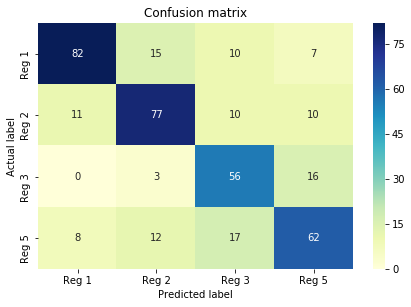

In [22]:
evaluate_performance(back_to_1_5(estimates), train_y)

### Validation

In [23]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 37
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.71      0.74        28
           2       0.79      0.73      0.76        30
           3       0.36      0.53      0.43        17
           5       0.57      0.48      0.52        25

   micro avg       0.63      0.63      0.63       100
   macro avg       0.62      0.61      0.61       100
weighted avg       0.66      0.63      0.64       100



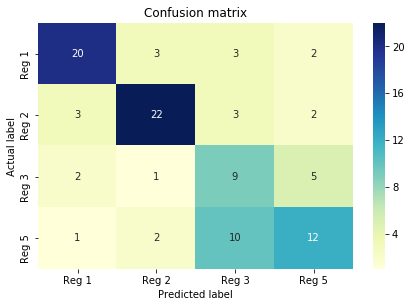

In [24]:
evaluate_performance(back_to_1_5(val_estimates), val_y)

### Bias-Variance Tradeoff

Text(0.5, 1.0, 'Training Loss')

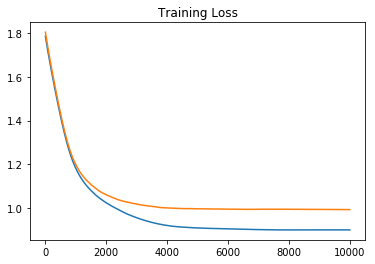

In [25]:
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title("Training Loss")

In [26]:
np.argmin(val_loss)

9981

## Retrain for the optimal number of epochs

In [59]:
# Use the nn package to define our model and loss function.
model2 = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

In [60]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=0.05)
train_loss = []
val_loss = []
for t in range(5600):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model2(x)
#     y_val_pred = model2(val)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    train_loss.append(loss)
    
#     loss_v = loss_fn(y_val_pred, v_y)
#     val_loss.append(loss_v)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 1.7592480182647705
1 1.7584011554718018
2 1.7575560808181763
3 1.756710171699524
4 1.755866289138794
5 1.7550228834152222
6 1.7541815042495728
7 1.753339171409607
8 1.7524991035461426
9 1.751658320426941
10 1.7508183717727661
11 1.7499816417694092
12 1.7491434812545776
13 1.7483084201812744
14 1.747472882270813
15 1.7466416358947754
16 1.7458094358444214
17 1.744977355003357
18 1.7441484928131104
19 1.7433193922042847
20 1.7424911260604858
21 1.7416634559631348
22 1.7408361434936523
23 1.7400085926055908
24 1.7391846179962158
25 1.7383602857589722
26 1.7375352382659912
27 1.73671293258667
28 1.73589026927948
29 1.7350674867630005
30 1.7342443466186523
31 1.733424186706543
32 1.7326034307479858
33 1.7317830324172974
34 1.7309637069702148
35 1.7301442623138428
36 1.7293262481689453
37 1.7285102605819702
38 1.7276943922042847
39 1.7268787622451782
40 1.7260645627975464
41 1.7252508401870728
42 1.724438190460205
43 1.7236260175704956
44 1.7228144407272339
45 1.7220021486282349
46 1.72118

367 1.4656658172607422
368 1.4648622274398804
369 1.464059829711914
370 1.4632561206817627
371 1.4624525308609009
372 1.4616492986679077
373 1.4608460664749146
374 1.4600415229797363
375 1.4592390060424805
376 1.4584355354309082
377 1.457633376121521
378 1.456830382347107
379 1.4560271501541138
380 1.4552239179611206
381 1.454420804977417
382 1.4536174535751343
383 1.4528145790100098
384 1.4520121812820435
385 1.4512091875076294
386 1.450406789779663
387 1.4496045112609863
388 1.4488019943237305
389 1.4479994773864746
390 1.4471968412399292
391 1.4463951587677002
392 1.4455933570861816
393 1.4447914361953735
394 1.4439901113510132
395 1.4431885480880737
396 1.4423872232437134
397 1.4415879249572754
398 1.440787672996521
399 1.439988613128662
400 1.4391875267028809
401 1.438387155532837
402 1.4375869035720825
403 1.436787486076355
404 1.4359867572784424
405 1.4351873397827148
406 1.4343876838684082
407 1.4335874319076538
408 1.4327870607376099
409 1.4319864511489868
410 1.43118691444396

768 1.1933507919311523
769 1.1928448677062988
770 1.192338466644287
771 1.1918338537216187
772 1.1913282871246338
773 1.19082510471344
774 1.190321683883667
775 1.189819097518921
776 1.1893171072006226
777 1.1888164281845093
778 1.1883162260055542
779 1.1878162622451782
780 1.1873183250427246
781 1.186821460723877
782 1.186326026916504
783 1.185829758644104
784 1.1853349208831787
785 1.1848416328430176
786 1.1843481063842773
787 1.1838558912277222
788 1.1833651065826416
789 1.182874083518982
790 1.1823853254318237
791 1.1818963289260864
792 1.1814090013504028
793 1.1809214353561401
794 1.1804357767105103
795 1.1799498796463013
796 1.1794652938842773
797 1.1789815425872803
798 1.1785000562667847
799 1.178017258644104
800 1.1775344610214233
801 1.1770544052124023
802 1.1765739917755127
803 1.176094889640808
804 1.1756155490875244
805 1.1751376390457153
806 1.1746611595153809
807 1.174184799194336
808 1.1737098693847656
809 1.173235535621643
810 1.1727619171142578
811 1.1722893714904785
8

1170 1.0494732856750488
1171 1.0492348670959473
1172 1.048996925354004
1173 1.0487592220306396
1174 1.0485219955444336
1175 1.0482845306396484
1176 1.0480482578277588
1177 1.0478113889694214
1178 1.0475761890411377
1179 1.0473401546478271
1180 1.0471045970916748
1181 1.046870470046997
1182 1.0466361045837402
1183 1.0464026927947998
1184 1.0461686849594116
1185 1.0459363460540771
1186 1.0457032918930054
1187 1.04547119140625
1188 1.0452394485473633
1189 1.0450084209442139
1190 1.0447770357131958
1191 1.044547438621521
1192 1.0443179607391357
1193 1.0440888404846191
1194 1.0438604354858398
1195 1.0436327457427979
1196 1.0434041023254395
1197 1.0431773662567139
1198 1.04295015335083
1199 1.0427250862121582
1200 1.04249906539917
1201 1.0422734022140503
1202 1.0420480966567993
1203 1.0418239831924438
1204 1.041600227355957
1205 1.0413765907287598
1206 1.041154384613037
1207 1.040932059288025
1208 1.0407099723815918
1209 1.0404874086380005
1210 1.0402660369873047
1211 1.0400452613830566
1212

1614 0.9732519388198853
1615 0.9731224179267883
1616 0.9729937314987183
1617 0.9728653430938721
1618 0.9727369546890259
1619 0.9726081490516663
1620 0.9724804759025574
1621 0.9723517894744873
1622 0.9722225069999695
1623 0.9720942974090576
1624 0.9719659686088562
1625 0.9718378782272339
1626 0.9717100262641907
1627 0.9715818166732788
1628 0.9714536666870117
1629 0.9713262915611267
1630 0.9711984395980835
1631 0.9710709452629089
1632 0.9709440469741821
1633 0.9708160758018494
1634 0.9706892371177673
1635 0.9705628752708435
1636 0.970436692237854
1637 0.9703108072280884
1638 0.9701849222183228
1639 0.9700585603713989
1640 0.9699327945709229
1641 0.9698065519332886
1642 0.9696802496910095
1643 0.9695556163787842
1644 0.9694293141365051
1645 0.96930330991745
1646 0.9691778421401978
1647 0.9690517783164978
1648 0.9689258337020874
1649 0.9688007235527039
1650 0.9686765670776367
1651 0.9685515761375427
1652 0.9684273600578308
1653 0.9683030247688293
1654 0.968178927898407
1655 0.9680541753768

2098 0.9214275479316711
2099 0.9213438034057617
2100 0.9212591648101807
2101 0.9211751818656921
2102 0.9210914969444275
2103 0.9210071563720703
2104 0.92092365026474
2105 0.9208396077156067
2106 0.9207560420036316
2107 0.9206717610359192
2108 0.9205887913703918
2109 0.9205045700073242
2110 0.920421302318573
2111 0.920337975025177
2112 0.9202547669410706
2113 0.9201717376708984
2114 0.9200888872146606
2115 0.920004665851593
2116 0.9199221134185791
2117 0.9198393225669861
2118 0.9197566509246826
2119 0.919674277305603
2120 0.9195908308029175
2121 0.9195088744163513
2122 0.919425904750824
2123 0.9193440675735474
2124 0.9192622900009155
2125 0.919180154800415
2126 0.9190986752510071
2127 0.9190168976783752
2128 0.9189352989196777
2129 0.918854296207428
2130 0.9187727570533752
2131 0.9186914563179016
2132 0.9186095595359802
2133 0.9185285568237305
2134 0.918448269367218
2135 0.9183675050735474
2136 0.9182870984077454
2137 0.9182056188583374
2138 0.9181241989135742
2139 0.9180437326431274
21

2564 0.8869357705116272
2565 0.8868695497512817
2566 0.8868045806884766
2567 0.8867394328117371
2568 0.8866739273071289
2569 0.8866096138954163
2570 0.8865450620651245
2571 0.8864801526069641
2572 0.8864157199859619
2573 0.8863502144813538
2574 0.8862853646278381
2575 0.8862215280532837
2576 0.8861579298973083
2577 0.8860934972763062
2578 0.8860299587249756
2579 0.8859657645225525
2580 0.8859016299247742
2581 0.8858380317687988
2582 0.8857743144035339
2583 0.885709822177887
2584 0.885646641254425
2585 0.885583221912384
2586 0.8855193853378296
2587 0.8854556083679199
2588 0.8853924870491028
2589 0.8853289484977722
2590 0.885265052318573
2591 0.8852012157440186
2592 0.885138213634491
2593 0.8850741982460022
2594 0.8850104808807373
2595 0.8849472403526306
2596 0.8848832845687866
2597 0.8848205804824829
2598 0.884757399559021
2599 0.8846938610076904
2600 0.8846308588981628
2601 0.8845664858818054
2602 0.8845030069351196
2603 0.8844395875930786
2604 0.8843755722045898
2605 0.884311854839325

3049 0.8615148663520813
3050 0.8614746332168579
3051 0.8614347577095032
3052 0.8613958358764648
3053 0.861356258392334
3054 0.8613165020942688
3055 0.8612766265869141
3056 0.8612378239631653
3057 0.8611993789672852
3058 0.8611598014831543
3059 0.8611199855804443
3060 0.8610799908638
3061 0.8610406517982483
3062 0.861001193523407
3063 0.8609611988067627
3064 0.8609209060668945
3065 0.8608819842338562
3066 0.8608422875404358
3067 0.8608022928237915
3068 0.8607624173164368
3069 0.8607226014137268
3070 0.8606831431388855
3071 0.8606435060501099
3072 0.860603928565979
3073 0.860564112663269
3074 0.8605248928070068
3075 0.8604853749275208
3076 0.8604457974433899
3077 0.8604064583778381
3078 0.8603664636611938
3079 0.8603276014328003
3080 0.8602885007858276
3081 0.8602487444877625
3082 0.8602094054222107
3083 0.8601707816123962
3084 0.8601319193840027
3085 0.8600924611091614
3086 0.860053539276123
3087 0.860014021396637
3088 0.8599758744239807
3089 0.8599373698234558
3090 0.8598988056182861
3

3541 0.8450440764427185
3542 0.8450179696083069
3543 0.8449922800064087
3544 0.8449667096138
3545 0.844940721988678
3546 0.8449150919914246
3547 0.8448904156684875
3548 0.8448649048805237
3549 0.8448396921157837
3550 0.8448136448860168
3551 0.8447889089584351
3552 0.8447641134262085
3553 0.8447393774986267
3554 0.8447139859199524
3555 0.8446885943412781
3556 0.8446633815765381
3557 0.8446376919746399
3558 0.844612717628479
3559 0.8445874452590942
3560 0.8445616364479065
3561 0.8445363640785217
3562 0.8445108532905579
3563 0.844485878944397
3564 0.8444610238075256
3565 0.8444364666938782
3566 0.8444115519523621
3567 0.8443861603736877
3568 0.8443613052368164
3569 0.8443366289138794
3570 0.8443118929862976
3571 0.8442864418029785
3572 0.8442611694335938
3573 0.8442366719245911
3574 0.8442116975784302
3575 0.8441872000694275
3576 0.8441619873046875
3577 0.84413743019104
3578 0.8441124558448792
3579 0.8440887928009033
3580 0.8440643548965454
3581 0.8440399169921875
3582 0.8440143465995789


4010 0.8343908190727234
4011 0.8343716263771057
4012 0.8343524932861328
4013 0.8343323469161987
4014 0.8343142867088318
4015 0.8342956304550171
4016 0.8342759013175964
4017 0.8342573642730713
4018 0.8342380523681641
4019 0.8342196345329285
4020 0.834200382232666
4021 0.8341820240020752
4022 0.834164023399353
4023 0.8341454267501831
4024 0.8341266512870789
4025 0.8341090679168701
4026 0.8340908288955688
4027 0.8340721726417542
4028 0.8340546488761902
4029 0.8340357542037964
4030 0.8340175151824951
4031 0.8339991569519043
4032 0.8339808583259583
4033 0.83396315574646
4034 0.8339446187019348
4035 0.8339267373085022
4036 0.8339090347290039
4037 0.8338904976844788
4038 0.8338728547096252
4039 0.8338561654090881
4040 0.8338381052017212
4041 0.8338204026222229
4042 0.8338028192520142
4043 0.8337852358818054
4044 0.8337676525115967
4045 0.8337504863739014
4046 0.8337329626083374
4047 0.8337159752845764
4048 0.8336989283561707
4049 0.8336808085441589
4050 0.8336636424064636
4051 0.8336458206176

4490 0.827237606048584
4491 0.8272255063056946
4492 0.8272138833999634
4493 0.8272011280059814
4494 0.8271893858909607
4495 0.8271761536598206
4496 0.8271644115447998
4497 0.8271540403366089
4498 0.8271422982215881
4499 0.8271307945251465
4500 0.8271194696426392
4501 0.8271070718765259
4502 0.8270948529243469
4503 0.8270840048789978
4504 0.8270718455314636
4505 0.8270605206489563
4506 0.8270488977432251
4507 0.8270376920700073
4508 0.8270255327224731
4509 0.8270134329795837
4510 0.8270010352134705
4511 0.8269898295402527
4512 0.8269774317741394
4513 0.826965868473053
4514 0.8269544839859009
4515 0.8269424438476562
4516 0.8269308805465698
4517 0.8269192576408386
4518 0.8269067406654358
4519 0.8268946409225464
4520 0.8268845677375793
4521 0.8268733024597168
4522 0.8268623948097229
4523 0.8268508911132812
4524 0.826839804649353
4525 0.8268289566040039
4526 0.8268172144889832
4527 0.8268066048622131
4528 0.8267956376075745
4529 0.8267842531204224
4530 0.8267731070518494
4531 0.826762020587

4896 0.8233795762062073
4897 0.8233687877655029
4898 0.823358416557312
4899 0.8233480453491211
4900 0.8233379125595093
4901 0.8233290314674377
4902 0.8233190774917603
4903 0.8233098387718201
4904 0.8233007788658142
4905 0.8232913613319397
4906 0.823281466960907
4907 0.8232721090316772
4908 0.823262631893158
4909 0.8232530355453491
4910 0.8232437968254089
4911 0.8232347965240479
4912 0.8232256174087524
4913 0.8232161402702332
4914 0.8232071995735168
4915 0.8231987357139587
4916 0.823189377784729
4917 0.8231810927391052
4918 0.8231714367866516
4919 0.8231619596481323
4920 0.823153555393219
4921 0.8231435418128967
4922 0.8231356143951416
4923 0.8231275081634521
4924 0.8231192827224731
4925 0.8231119513511658
4926 0.8231033086776733
4927 0.8230941295623779
4928 0.8230853080749512
4929 0.8230764269828796
4930 0.8230667114257812
4931 0.8230574131011963
4932 0.8230481147766113
4933 0.8230385184288025
4934 0.8230301141738892
4935 0.8230198621749878
4936 0.8230099678039551
4937 0.82300072908401

5326 0.8204320073127747
5327 0.820427417755127
5328 0.8204229474067688
5329 0.8204184770584106
5330 0.8204126954078674
5331 0.8204071521759033
5332 0.8204025030136108
5333 0.8203971982002258
5334 0.8203922510147095
5335 0.8203869462013245
5336 0.8203819990158081
5337 0.8203772902488708
5338 0.8203732371330261
5339 0.8203688859939575
5340 0.8203639984130859
5341 0.8203595876693726
5342 0.8203555941581726
5343 0.8203505873680115
5344 0.8203445076942444
5345 0.8203396201133728
5346 0.8203357458114624
5347 0.8203317523002625
5348 0.8203271627426147
5349 0.8203221559524536
5350 0.8203173279762268
5351 0.8203122019767761
5352 0.8203064203262329
5353 0.8203020095825195
5354 0.8202980160713196
5355 0.8202940821647644
5356 0.8202895522117615
5357 0.8202846646308899
5358 0.820279598236084
5359 0.8202748894691467
5360 0.820270836353302
5361 0.8202662467956543
5362 0.8202618956565857
5363 0.8202571868896484
5364 0.8202522397041321
5365 0.8202465176582336
5366 0.820242702960968
5367 0.8202375173568

In [61]:
val_scores = model(torch.FloatTensor(val_X))
val_scores_np = val_scores.detach().numpy()

val_estimates = np.argmax(val_scores_np, axis=1)

Misclassified samples: 34
Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.67      0.75        33
           2       0.75      0.81      0.78        26
           3       0.60      0.54      0.57        28
           5       0.38      0.62      0.47        13

   micro avg       0.66      0.66      0.66       100
   macro avg       0.64      0.66      0.64       100
weighted avg       0.69      0.66      0.67       100



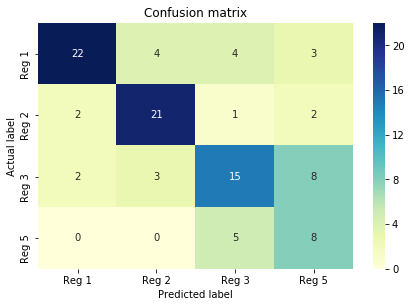

In [62]:
evaluate_performance(back_to_1_5(val_estimates), val_y)